# Tests

In [1]:
include("AgeStructuredModels.jl")
include("DemographicParameters.jl")
using Plots
theme(:wong2)

┌ Info: Precompiling Roots [f2b01f46-fcfa-551c-844a-d8ac1e96c665]
└ @ Base loading.jl:1278


In [2]:
mod = AgeStructuredModels.init(150,DemographicParameters.Smyth_2016_sr,DemographicParameters.Smyth_2016_survival,
    DemographicParameters.Smyth_16_F_vec)

Main.AgeStructuredModels.model(150, Main.DemographicParameters.StockRecruitCurves.BevetonHolt(1.0857858066696926e-11, 1.3867604694043434e-13, 62.63725167395758, 5.0, 4.6049598081742584e11), [3.3594663117871173e6 2.555056808609395e7 … 8.824231836110345e10 8.829850322467499e10; 0.96 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.96 0.0], [0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96  …  0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96], [3.3594663117871173e6, 2.555056808609395e7, 8.200477974415235e7, 1.849036857751277e8, 3.4363008204794115e8, 5.651657119512861e8, 8.544414600074257e8, 1.2146452254678285e9, 1.6474921509710765e9, 2.1534613897204194e9  …  8.771809151502399e10, 8.779155158148238e10, 8.786259495692207e10, 8.793129987574011e10, 8.799774212388702e10, 8.806199510984056e10, 8.812412993391338e10, 8.818421545590387e10, 8.824231836110345e10, 8.829850322467499e10])

In [3]:
R_star = AgeStructuredModels.compute_Rstar(mod)

62.63725167395758

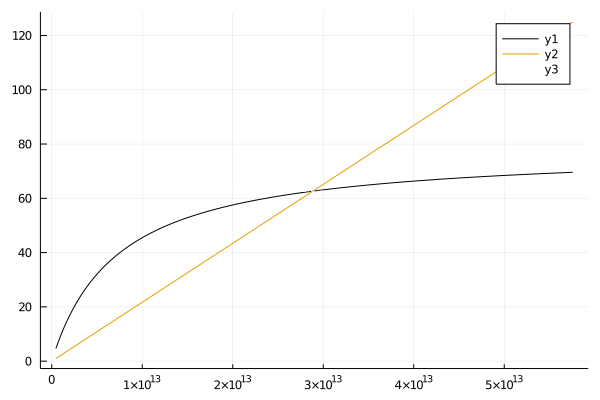

In [4]:
lep = AgeStructuredModels.LEP(mod)
x = lep * (1:2*R_star) 
Plots.plot(x,mod.SRCurve.(x) )
Plots.plot!(x, x/lep)
Plots.plot!(x, repeat([R_star], length(x)), linestyle = :dashdot, color = "white")

In [5]:
sum(AgeStructuredModels.stable_age_structure(mod))

1562.4999999999998

# Test demographics in `AgeTraitStructuredModels`

when the popuatlion models are initiated I want them to be at equilibrium in that absence of immigration (only experince selection and density dependence). To determine if I have calcualted these quantities correctly I have compared the expected equilibrium recruitment to the output of the model after simulation for 100 years (~ 2 generations) under a range of alternative model paramters and structures. In particular I will test, varying the stock recruit curve shape paramters $k$ and the strength of selection $s$. I will also test cases where density dependence comes before and after seleciton.

┌ Info: Precompiling DSP [717857b8-e6f2-59f4-9121-6e50c889abd2]
└ @ Base loading.jl:1278


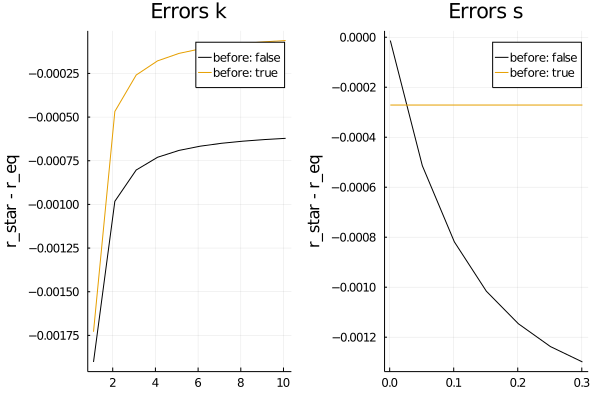

In [6]:
include("AgeTraitStructuredModels.jl")
include("StockRecruitCurves.jl")
# define the dynamics of the population 
function time_step!(population,before)
    if before
        dsn, R = AgeTraitStructuredModels.reproduction(population)
        dsn, R = AgeTraitStructuredModels.selection(dsn, R, population)
        R = AgeTraitStructuredModels.recruitment(R, population, before)
        AgeTraitStructuredModels.ageing!(population, R, dsn)
    else
        dsn, R = AgeTraitStructuredModels.reproduction(population)
        R = AgeTraitStructuredModels.recruitment(R, population, before)
        dsn, R = AgeTraitStructuredModels.selection(dsn, R, population)
        AgeTraitStructuredModels.ageing!(population, R, dsn)
    end 
end

function equilibrium(k,s,before)
    pop = AgeTraitStructuredModels.init(mod,1, 0, 0.1, -5, 20, 0.1)
    AgeTraitStructuredModels.reset!(pop,s)
    StockRecruitCurves.update_BevetonHolt_k!(pop.ageStructure.SRCurve, k)
    R_star = R_star = AgeStructuredModels.compute_Rstar(pop.ageStructure)
    for i in 1:200
        time_step!(pop,before)
    end 
    return R_star, AgeTraitStructuredModels.recruitment(pop)
end 
k = 1.1:1.0:10.1
vals = broadcast(x -> equilibrium(x,0.1,false), k)
p1 = Plots.plot(k, broadcast(i -> vals[i][1] - vals[i][2], 1:length(k)), title = "Errors k", label = "before: false")
vals = broadcast(x -> equilibrium(x,0.1,true), k)
Plots.plot!(k, broadcast(i -> vals[i][1] - vals[i][2], 1:length(k)), title = "Errors k", label = "before: true", ylabel = "r_star - r_eq")

s = 0.001:0.05:0.301
vals = broadcast(x -> equilibrium(3.0,x,false), s)
p2 = Plots.plot(s, broadcast(i -> vals[i][1] - vals[i][2], 1:length(s)), title = "Errors s", label = "before: false")
vals = broadcast(x -> equilibrium(3.0,0.1,true), s)
Plots.plot!(s, broadcast(i -> vals[i][1] - vals[i][2], 1:length(s)), title = "Errors s", label = "before: true", ylabel = "r_star - r_eq")
plot(p1,p2)

The differnce between the equilibirum recruitment I calcualted and the equilbirium of the simulation were very similar less than 0.002 differnces (compared to a true value of 60) in all cases. These slight differnces are likely caused by differnces in the equilibrium genetic state calcualted using the exact formulas for normal distributions and the grid aproximation used for the simulation.  

# Test `AgeTraitStructuredModel genetics

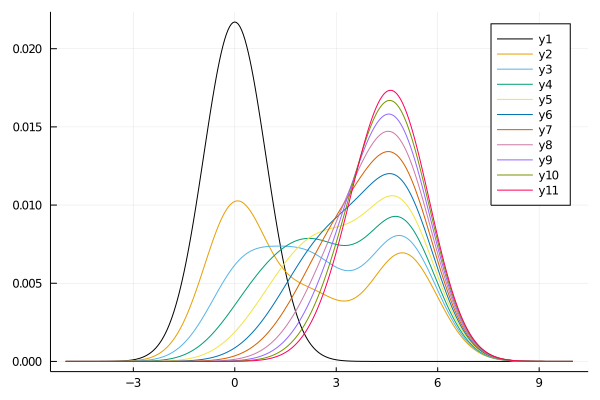

In [7]:
# initialize a populaiton 
pop = AgeTraitStructuredModels.init(mod,1, 0, 0.1, -5, 10, 0.05)

im = AgeTraitStructuredModels.init_imigrants(pop, 30.0, 5)
print(" ")

function time_step!(population,immigrants)
    dsn, R = AgeTraitStructuredModels.reproduction(population)
    R = AgeTraitStructuredModels.recruitment(R, population )
    dsn, R = AgeTraitStructuredModels.selection(dsn, R, population)
    dsn, R = AgeTraitStructuredModels.immigration(dsn, R, immigrants)
    AgeTraitStructuredModels.ageing!(population, R, dsn)
end 

p1 = Plots.plot(pop.grid, pop.trait[:,1])
for i in 1:500
    time_step!(pop,im)
    if i% 50 == 0
        Plots.plot!(p1, pop.grid, pop.trait[:,1])
    end 
end 
p1

# Test model with analytical solution

In [8]:
# analytical methods 
using Distributions
function reproduction(mu, sigma, Vle)
    means = mu
    sds = sqrt((sigma^2)/2 + Vle/2)
    return  means, sds
end 

function reproduction(p, mu, sigma, Vle)
    probs = [p^2, 2*p*(1-p), (1-p)^2]
    means = [mu[1], sum(mu)/2, mu[2]]
    sds = [sqrt((sigma[1]^2)/2 + Vle/2) , sqrt(((sigma[1]^2)/2+(sigma[2]^2)/2)/2 + Vle/2  ), sqrt((sigma[2]^2)/2 + Vle/2)]
    return probs, means, sds
end 

function selection(mu, sigma, s, theta)
    mu_prime = (mu/sigma^2 + s*theta)*(1/sigma^2+s)^(-1)
    sigma_prime = (1/sigma^2+s)^(-1/2)
    print((mu/sigma)^2 + s*theta^2 -(mu_prime/sigma_prime)^2)
    p = exp(-1/2*((mu/sigma)^2 + s*theta^2 -(mu_prime/sigma_prime)^2))
    p *= sigma_prime/sigma
    return mu_prime, sigma_prime, p
end 


function moments(grid, values)
    values = values./sum(values)
    mu = sum(grid .* values)
    sigma = sqrt(sum(values.*(grid.-mu).^2))
    return mu, sigma 
end 

moments (generic function with 1 method)

In [284]:
Survival,Fecundity = [0.9,0.0],[0.0,3.0]
mat = AgeStructuredModels.build_leslie_matrix(2,Survival,Fecundity)
mod2 = AgeStructuredModels.model(2,x -> x*exp(1-x),mat,Survival,Fecundity) 



# initialize a populaiton 
Vle = 1.0
s = 0.1
theta = 0 
pop2 = AgeTraitStructuredModels.init(mod2,Vle, theta, s, -20, 12, 0.025)

print(" ")


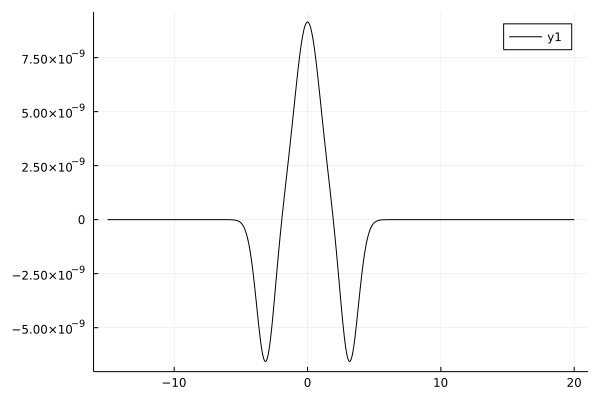

In [305]:
## test reproduction with unimodal distribution 
pop2 = AgeTraitStructuredModels.init(mod2,Vle, theta, s, -15, 20, 0.001)
mu, sigma = moments(pop2.grid, pop2.trait[:,2])
dsn, R = AgeTraitStructuredModels.reproduction(pop2)
mu, sigma = reproduction(mu, sigma, Vle)
pdf1 = broadcast(x -> pdf(Distributions.Normal(mu,sigma),x),pop2.grid)
Plots.plot(pop2.grid, dsn .- pdf1./sum(pdf1))


# dsn, R = AgeTraitStructuredModels.immigration(dsn, R, immigrants)

9.989918042705056e-36

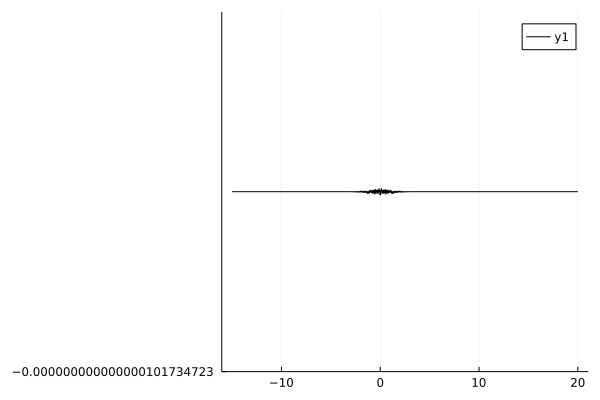

In [299]:
## test selection 
pop2 = AgeTraitStructuredModels.init(mod2,Vle, theta, s, -15, 20, 0.01)
mu, sigma = moments(pop2.grid, pop2.trait[:,2])

dsn, R = AgeTraitStructuredModels.selection(pop2.trait[:,2], 1, pop2)
mu, sigma, p = selection(mu, sigma, s, theta)

pdf1 = broadcast(x -> pdf(Distributions.Normal(mu,sigma),x),pop2.grid)
p1 = Plots.plot(pop2.grid, dsn .- pdf1./sum(pdf1))
#Plots.plot!(p1,pop2.grid, pdf1./sum(pdf1))
   
        
plot(p1)

In [300]:
floor(R, digits = 4) == floor(p,digits = 4)

true

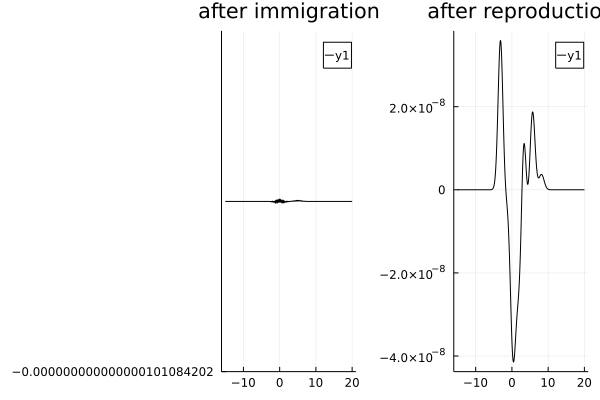

In [301]:
# test immigration 
pop2 = AgeTraitStructuredModels.init(mod2,Vle, theta, s, -15, 20, 0.01)
mu, sigma = moments(pop2.grid, pop2.trait[:,2])
im = AgeTraitStructuredModels.init_imigrants(pop2, 1.0, 5)


dsn, R = AgeTraitStructuredModels.immigration(pop2.trait[:,2], 3.0, im)
p = [0.75, 0.25]


mu = [mu, 5.0]
sigma = [sigma, sqrt(Vle)] 
pdf_ =  x ->  p[1]*pdf(Distributions.Normal(mu[1],sigma[1]),x) + p[2]*pdf(Distributions.Normal(mu[2],sigma[2]),x)

p1 = Plots.plot(pop2.grid, dsn.-pdf_.(pop2.grid)./sum(pdf_.(pop2.grid)), 
                title = "after immigration")





# test reproduction, multimodal

p, mu, sds = reproduction(p[1], mu, sigma, Vle)

pdf1 =  x -> sum(broadcast( i -> p[i]*pdf(Distributions.Normal(mu[i],sds[i]),x),1:3))
    




pop2 = AgeTraitStructuredModels.init(mod2,Vle, theta, s, -15, 20, 0.01)
pop2.trait[:,2] = dsn
dsn, R = AgeTraitStructuredModels.reproduction(pop2)
p2 = Plots.plot(pop2.grid,pdf1.(pop2.grid)./sum(pdf1.(pop2.grid)) .- dsn, title = "after reproduction")
#Plots.plot!(p2, pop2.grid  , dsn)

plot(p1,p2)

# Test `HatcheryPopulaitons.jl`



In [132]:
include("HatcheryPopulations.jl")

Main.HatcheryPopulations

In [133]:
mod = AgeStructuredModels.init(150,DemographicParameters.Smyth_2016_sr,DemographicParameters.Smyth_2016_survival,
    DemographicParameters.Smyth_16_F_vec)

# params
Vle = 1.0
theta_N = 0.0
s_N = 0.1

theta_D = 5.0
s_D = 0.1

dx = 0.1
min = -4
max = 9

hatch_pop = HatcheryPopulations.init(mod, Vle, theta_N, s_N, theta_D, s_D, min, max, dx)
print(" ")

In [140]:
HatcheryPopulations.reset!(hatch_pop, 0.05,0.1,0.2,5.0)


0.05

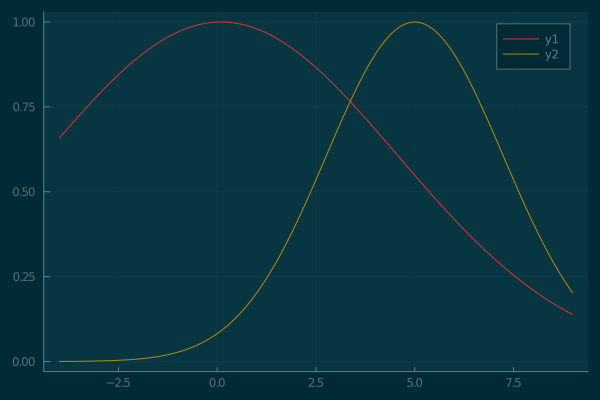

In [141]:
Plots.plot(hatch_pop.grid,hatch_pop.natural_gradient)
Plots.plot!(hatch_pop.grid,hatch_pop.domestic_gradient)

In [1]:
using Roots

In [8]:
f(x) = x-1.51
Roots.find_zeros(f,[0,2.0])

1-element Vector{Float64}:
 1.51

In [ ]:
broadcast